# This notebook allows you to compare integrations of the averaged Hamiltonian for a first order Mean Motion Resonance to a full N-body integration

We start by importing all the libraries we need and setting up the variables we need for symbolic manipulation

In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos
import numpy as np
import rebound
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha = symbols("m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha")
J1, J2, Gamma1, Gamma2, phi1, phi2 = symbols("J1, J2, Gamma1, Gamma2, phi1, phi2")
f27 = -0.46 - 0.802*m
f31 = 0.87 + 0.802*m
H = -mu1/(2.*Lambda1**2) - mu2/(2.*Lambda2**2) - m1/M1*mu2/Lambda2**2*(f27*sqrt(2.*P1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + p1) + f31*sqrt(2.*P2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + p2))

# This is the Hamiltonian in Deck et al. Eq 6 (with their notation):

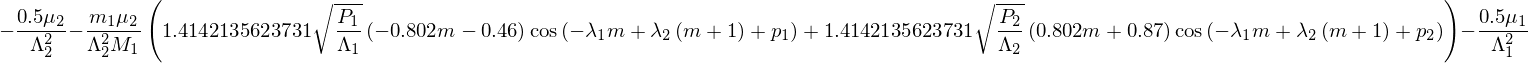

In [3]:
H

# Now I transform to 2 degrees of freedom (for $\phi_1$ and $\phi_2$) using Eq 5 in El Moutamid et al.

$J_1$ and $J_2$ are now constants of motion, and the $\phi$ variables are conjugate to the $\Gamma$ variables.  

In [4]:
H2 = H
H2 = H2.subs(P1, Gamma1)
H2 = H2.subs(P2, Gamma2)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p1, phi1)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p2, phi2)
H2 = H2.subs(Lambda1, J1 - m*(Gamma1 + Gamma2))
H2 = H2.subs(Lambda2, J2 + (m+1)*(Gamma1 + Gamma2))

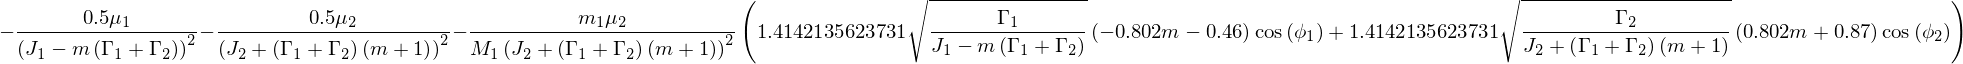

In [5]:
H2

# Calculate Hamilton's equations symbolically

In [6]:
var = (mu1, J1, m, mu2, J2, m1, M1, phi1, phi2, Gamma1, Gamma2)
params = (mu1, J1, m, mu2, J2, m1, M1)

In [7]:
Gamma1dot = lambdify(var, -diff(H2, phi1), 'numpy')
Gamma2dot = lambdify(var, -diff(H2, phi2), 'numpy')
phi1dot = lambdify(var, diff(H2, Gamma1), 'numpy')
phi2dot = lambdify(var, diff(H2, Gamma2), 'numpy')

In [8]:
def diffeq(y, t, *var):
    phi1, phi2, Gamma1, Gamma2 = y
    var = np.concatenate((var,y))
    dydt = [phi1dot(*var), phi2dot(*var), Gamma1dot(*var), Gamma2dot(*var)]
    return dydt

# Convenience functions for REBOUND Nbody integration

In [9]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

def phi(self):
    return (m+1)*self._sim.contents.particles[2].l - m*self._sim.contents.particles[1].l - self.pomega

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)
rebound.Particle.phi = property(phi)

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

# Parameters for the integrations 

You can also mess around with these!

In [10]:
m=2. # m-value for resonance, i.e. resonance is m+1:m
e0 = 1.e-3 # initial eccentricity of planets
Norbits = 1000 # number of inner planet orbits to integrate for
Nout = 10000 # number of output points

# This function does an N-body integration and a numerical integration of Hamilton's equations we derived symbolically above

In [11]:
def integrate(logmass, variable):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=10**logmass, e=e0, P=1.)
    sim.add(m=10**logmass, e=e0, P=(m+1)/m)
    sim.move_to_com()
    ps = sim.particles
    ps[1].hash = 1
    ps[2].hash = 2

    y0 = (ps[1].phi, ps[2].phi, ps[1].Gamma, ps[2].Gamma)
    params0 = (ps[1].mu, ps[1].J, m, ps[2].mu, ps[2].J, ps[1].mjac, ps[1].Mjac)

    tmax = Norbits*sim.particles[1].P
    times = np.linspace(0, tmax, Nout, endpoint=False)

    phi1, phi2, Gamma1, Gamma2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        phi1[i] = ps[1].phi
        phi2[i] = ps[2].phi
        Gamma1[i] = ps[1].Gamma
        Gamma2[i] = ps[2].Gamma

    phi1=npwrap(phi1)
    phi2=npwrap(phi2)

    sol = odeint(diffeq, y0, times, args=params0)
    Hphi1 = npwrap(sol[:,0])
    Hphi2 = npwrap(sol[:,1])
    HGamma1 = sol[:,2]
    HGamma2 = sol[:,3]
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
    ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
    ax.set_ylabel(variable, fontsize=24)
    
    if variable == 'Gamma1':
        ax.plot(times, HGamma1, '.', label='Hamiltonian')
        ax.plot(times, Gamma1, '.', label='Nbody')
    elif variable == 'Gamma2':
        ax.plot(times, HGamma2, '.', label='Hamiltonian')
        ax.plot(times, Gamma2, '.', label='Nbody')
    elif variable == 'phi1':
        ax.plot(times, Hphi1, '.', label='Hamiltonian')
        ax.plot(times, phi1, '.', label='Nbody')
    elif variable == 'phi2':
        ax.plot(times, Hphi2, '.', label='Hamiltonian')
        ax.plot(times, phi2, '.', label='Nbody')
    
    ax.legend()
    fig.show()

# Make a widget to play around with

You can set the logmass of the planets, and choose which of the 4 variables to plot

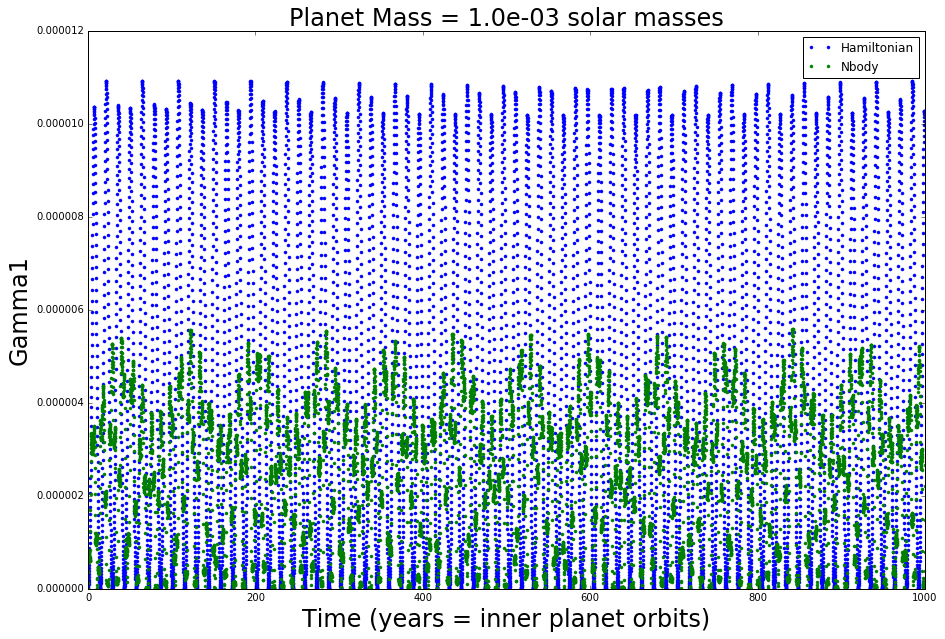

In [12]:
widgets.interact(integrate, logmass=FloatSlider(min=-7, max=-3, step=0.1, value=-5, continuous_update=False), variable=('Gamma1', 'Gamma2', 'phi1', 'phi2'))